In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from gensim.models import Word2Vec

In [79]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [80]:
tr = pd.read_csv('train.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
ev = pd.read_csv('evaluation.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})
test = pd.read_csv('test.csv', sep= ';', encoding= 'latin1', dtype={'': 'int', 'title': 'string', 'text': 'string', 'label': 'int'})

dataset = pd.concat([tr, ev, test], axis=0, ignore_index=True)

In [81]:
print('Nombre de las columnas:\n', dataset.columns)
print('\nDimensiones de los datos: ', dataset.shape)
print('\nValores ausentes:\n', dataset.isnull().sum())

Nombre de las columnas:
 Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')

Dimensiones de los datos:  (40587, 4)

Valores ausentes:
 Unnamed: 0    0
title         0
text          0
label         0
dtype: int64


La columna Unnamed: 0 contiene la posición en la base de datos de cada muestra. No es relevante para el estudio y se va a eliminar de la base de datos.

In [82]:
dataset = dataset.drop(columns=['Unnamed: 0'])
print(dataset.shape)

(40587, 3)


# Análisis exploratorio

## Análisis de la característica title

In [83]:
freq = dataset.value_counts('title')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de title"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de title
0            1                       39605
1            2                         375
2            3                           9
3            4                           2
4           14                           1
5          153                           1
6            5                           1
7            6                           1
8            8                           1
9           11                           1


Como podemos ver la mayoría de titulares de noticia son únicos, es decir, que aparecen una única vez. Los titulares con más de una aparición puede que se deba a que se hayan cogido diferentes fragmentos de una noticia como muestras distintas, pero el titular se comparte entre ellas. En caso de que no fuera así y hubiera muestras repetidas lo podríamos comprobar cuando analicemos la característica text. Si comparte las mismas apariciones que esta característica significará que hay muestras repetidas y las eliminaremos de la base de datos.

## Análisis de la característica text

In [84]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40583
1            2                          2


Podemos ver que solo hay dos pares de muestras repetidas lo que confirma nuestra teoría para la característica title. Por lo tanto, únicamente tenemos que eliminar una de las muestras de cada par duplicado.

In [85]:
dataset = dataset.drop_duplicates(subset='text', keep='first')

In [86]:
freq = dataset.value_counts('text')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de text"]
print(df_histograma_frecuencias)

   Apariciones  Número de valores de text
0            1                      40585


In [87]:
num_palabras = dataset['text'].apply(lambda x: len(str(x).split()))
media_palabras = num_palabras.mean()

min_palabras = num_palabras.min()
max_palabras = num_palabras.max()

cantidad_50_o_menos = (num_palabras <= 50).sum()

print("Media de palabras:", media_palabras)
print("Mínimo número de palabras:", min_palabras)
print("Máximo número de palabras:", max_palabras)
print("Número de muestras con 50 palabras o menos:", cantidad_50_o_menos)

Media de palabras: 407.95843291856596
Mínimo número de palabras: 0
Máximo número de palabras: 8135
Número de muestras con 50 palabras o menos: 1527


Q1: 211.0
Q2 (mediana): 367.0
Q3: 514.0
Media: 407.95843291856596


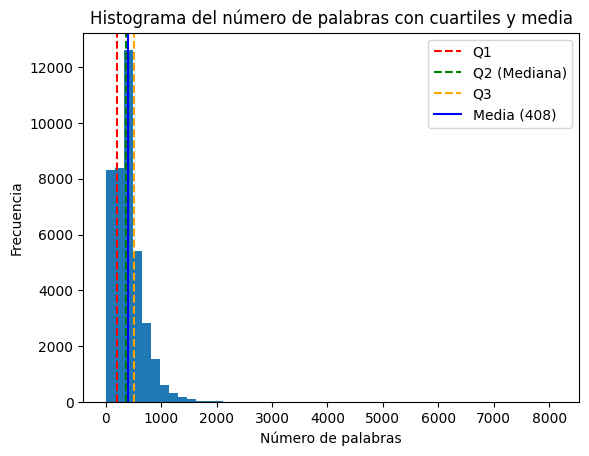

In [88]:
q1 = num_palabras.quantile(0.25)
q2 = num_palabras.quantile(0.50)   # mediana
q3 = num_palabras.quantile(0.75)

print("Q1:", q1)
print("Q2 (mediana):", q2)
print("Q3:", q3)
print("Media:", num_palabras.mean())  # debería ser 408

plt.hist(num_palabras, bins=50)
plt.axvline(q1, color='red', linestyle='--', label='Q1')
plt.axvline(q2, color='green', linestyle='--', label='Q2 (Mediana)')
plt.axvline(q3, color='orange', linestyle='--', label='Q3')
plt.axvline(408, color='blue', linestyle='-', label='Media (408)')

plt.xlabel('Número de palabras')
plt.ylabel('Frecuencia')
plt.title('Histograma del número de palabras con cuartiles y media')
plt.legend()
plt.show()


Quitamos las muestras con menos de 50 palabras al no ser suficientemente largo para el modelo, además de recortar los textos que son muy largos con un máximo de 1000 palabras

In [89]:
dataset = dataset[num_palabras >= 100].reset_index(drop=True)
print(dataset.shape)


def recortar_texto(texto, limite=1000):
    palabras = str(texto).split()
    if len(palabras) > limite:
        palabras = palabras[:limite]
    return " ".join(palabras)

dataset["text"] = dataset["text"].apply(recortar_texto)
num_palabras = dataset["text"].apply(lambda x: len(str(x).split()))
print("Máximo número de palabras ahora:", num_palabras.max())



(35241, 3)
Máximo número de palabras ahora: 1000


## Análisis de la característica label

In [90]:
freq = dataset.value_counts('label')
histograma_frecuencias = freq.value_counts(dropna=False)
histograma_frecuencias.name = "Frecuencia"
df_histograma_frecuencias = histograma_frecuencias.reset_index()
df_histograma_frecuencias.columns = ["Apariciones", "Número de valores de label"]
print(dataset['label'].value_counts(normalize=True) * 100)
print(df_histograma_frecuencias)

label
1    51.607503
0    48.392497
Name: proportion, dtype: float64
   Apariciones  Número de valores de label
0        18187                           1
1        17054                           1


<Axes: >

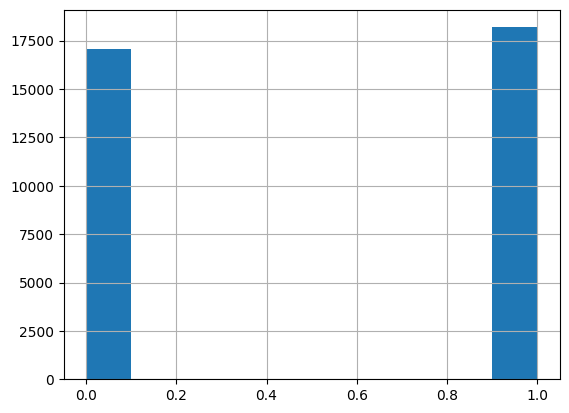

In [91]:
dataset['label'].hist()

Podemos ver que más o menos tenemos la misma cantidad de muestras con etiqueta 0 y 1, convirtiendo esta base de datos en adecuada para el entrenamiento de una red neuronal.

Separamos la base de datos en tres: entrenamiento, validación y test

In [92]:
dataset = dataset.drop(index=0).reset_index(drop=True)

# 10% train, 90% temp
train, temp = train_test_split(dataset, test_size=0.90, random_state=42)
# El 90% restante se divide en 50/50 -> 45% val, 45% test
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)

# Separar características y etiquetas
X_train = train.drop(columns=['label'])
y_train = train['label']

X_val = val.drop(columns=['label'])
y_val = val['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Comprobar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


(3524, 3)
(15858, 3)
(15858, 3)
X_train: (3524, 2) y_train: (3524,)
X_val: (15858, 2) y_val: (15858,)
X_test: (15858, 2) y_test: (15858,)


# Modelado de un algoritmo de clasificación

## TfidfVectorizer

Hemos decidido utilizar el algoritmo RandomForestClassifier para comparar su desempeño

In [93]:
#Usamos solo la columna 'text' como entrada de texto
X_train_text = X_train["text"]
X_val_text = X_val["text"]
X_test_text = X_test["text"]

#Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [ ]:
#Modelo de scikit-learn
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train_tfidf, y_train)

#Evaluación en validación y test
y_val_pred = clf.predict(X_val_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

print("=== Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("=== Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Validación ===
Accuracy val: 0.9752806154622272
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7756
           1       0.98      0.97      0.98      8102

    accuracy                           0.98     15858
   macro avg       0.98      0.98      0.98     15858
weighted avg       0.98      0.98      0.98     15858

=== Test ===
Accuracy test: 0.9772354647496532
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      7600
           1       0.98      0.97      0.98      8258

    accuracy                           0.98     15858
   macro avg       0.98      0.98      0.98     15858
weighted avg       0.98      0.98      0.98     15858



Obtenemos unos resultados extrañamente buenos. Antes de continuar analicemos las variables (que seran los tokens) que más peso tienen en la decisión del algoritmo de clasificación Random Forest

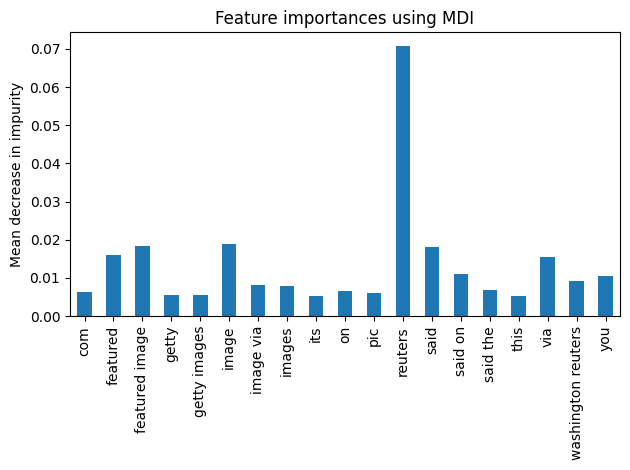

In [95]:
importances = clf.feature_importances_
feature_index = [i for i in range(X_train_tfidf.shape[1])]
words = [ p for p in vectorizer.get_feature_names_out()[feature_index] ]

filtro = importances > 0.005
relevant = importances[filtro] # Las importances que cumplen el filtro
relevant_words = np.array(words)[filtro] # Las palabras que cumplen el filtro

forest_importances = pd.Series(relevant, index=relevant_words)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Vemos que la palabra más importante es "reuters" que resulta ser el nombre de una agencia de noticias. Veamos que noticias tienen la palabra "reuters" y que coincidencia tienen con "label". Añadimos una nueva columna "reuters" que será 1 si el texto tiene la palabra "reuters" y 0 en otro caso.

In [96]:
dataset["reuters"] = dataset["text"].str.contains("reuters", case=False, na=False).astype(int)

In [97]:
print("Coincidencias: ", (dataset['label']==dataset['reuters']).sum()/len(dataset)*100 )


Coincidencias:  97.7383654937571


Vemos que en el 97,7% de las noticias, la columna label coincide con la columna reuters. Por tanto un clasificador tan sencillo como que devuelva 1 (noticia verdadera) cuando aparece la palabra "reuters" y 0 en otro caso (noticia falsa) ya tendría una tasa de acierto del 97,7%. Eso es por la contrucción del conjunto de datos, seguramente las noticias verdaderas salen de esta agencia de noticias y estan firmadas. Veamos algunos ejemplos

In [98]:
print( pd.DataFrame( { "text": dataset["text"].str[:50] + "...", 
                       "label": dataset["label"],
                       "reuters": dataset["reuters"] } ).head(30) )

                                                     text  label  reuters
0   While the controversy over Trump s personal tax re...      0        0
1   BEIJING (Reuters) - A trip to Beijing last week by...      1        1
2   There has never been a more UNCOURAGEOUS person in...      0        0
3   BAUCHI, Nigeria (Reuters) - Suspected Boko Haram s...      1        1
4   John Oliver isn t known for mincing words when it ...      0        0
5   WASHINGTON (Reuters) - Nine Democratic senators as...      1        1
6   Donald Trump sure knows how to add insult to injur...      0        0
7   I know Patty and I are boycotting Macy s for dumpi...      0        0
8   SEOUL/TOKYO (Reuters) - Detonating a nuclear-tippe...      1        1
9   PRAGUE (Reuters) - Czech police have requested par...      1        1
10  Trump is going to win in a landslide, but wouldn t...      0        0
11  Ted Cruz accused Senator Al Franken of lying about...      0        0
12  WASHINGTON/NEW YORK (Reuters) - As

Claramente la palabra "reuters" resulta una pista demasiado fácil para el clasificador. Si tiene la palabra "reuters" es verdadera y si no es falsa. Si entrenamos un clasificador con estos datos aprenderá atajos propios de los datos y difícilmente generalizará para otras noticias que no sigan el mismo patrón, pero que también pueden ser verdaderas. Para evitar este sesgo, eliminamos esta palabra.

In [ ]:
def limpiar_fuente_reuters(text):
    if pd.isna(text):
        return text
    
    # Quitar cabecera tipo:
    # "BAUCHI, Nigeria (Reuters) - "
    # "SEOUL/TOKYO (Reuters) - "
    # "RICHMOND, VA. (Reuters) - "
    # "(Reuters) - "
    text = re.sub(
        r'^\s*'                       # inicio + espacios
        r'.{0,80}?'                   # hasta 80 caracteres (ciudad, país, etc.)
        r'\(reuters\)\s*[-:–—]\s*',   # (Reuters) seguido de -, :, etc.
        '',
        text,
        flags=re.IGNORECASE
    )

    return text


# Nueva columna sin sesgo de Reuters
dataset["text_without_reuters"] = (
    dataset["text"]
      .apply(limpiar_fuente_reuters)
      .str.strip()
      .str.lower()
)

porcentaje_con_reuters = (
    dataset["text_without_reuters"]
      .str.contains("reuters", case=False, na=False)
      .mean() * 100
)

print(f"Porcentaje de textos que todavía contienen 'reuters': {porcentaje_con_reuters:.2f}%")

Porcentaje de textos que todavía contienen 'reuters': 14.27%


Repetimos el algoritmo sobre la columna "text_without_reuters_said"

In [ ]:
dataset = dataset.drop(index=0).reset_index(drop=True)

# 30% train, 70% temp
train, temp = train_test_split(dataset, test_size=0.70, random_state=42)
# El 70% restante se divide en 50/50 -> 35% val, 35% test
val, test = train_test_split(temp, test_size=0.5, random_state=42)

print(train.shape)
print(val.shape)
print(test.shape)

# Separar características y etiquetas
X_train = train.drop(columns=['label'])
y_train = train['label']

X_val = val.drop(columns=['label'])
y_val = val['label']

X_test = test.drop(columns=['label'])
y_test = test['label']

# Comprobar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


(10571, 5)
(12334, 5)
(12334, 5)
X_train: (10571, 4) y_train: (10571,)
X_val: (12334, 4) y_val: (12334,)
X_test: (12334, 4) y_test: (12334,)


In [101]:
#Usamos solo la columna 'text_without_reuter' como entrada de texto
X_train_text = X_train["text_without_reuters"]
X_val_text = X_val["text_without_reuters"]
X_test_text = X_test["text_without_reuters"]

#Vectorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1, 2), lowercase=True)
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)
X_test_tfidf = vectorizer.transform(X_test_text)

In [ ]:
#Modelo de scikit-learn RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train_tfidf, y_train)

#Evaluación en validación y test
y_val_pred = clf.predict(X_val_tfidf)
y_test_pred = clf.predict(X_test_tfidf)

print("=== Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

print("=== Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

=== Validación ===
Accuracy val: 0.9681368574671639
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      6051
           1       0.96      0.98      0.97      6283

    accuracy                           0.97     12334
   macro avg       0.97      0.97      0.97     12334
weighted avg       0.97      0.97      0.97     12334

=== Test ===
Accuracy test: 0.9643262526349927
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5975
           1       0.96      0.97      0.97      6359

    accuracy                           0.96     12334
   macro avg       0.96      0.96      0.96     12334
weighted avg       0.96      0.96      0.96     12334



La precisión del algoritmo ha bajado, pero no de forma espectacular. Analicemos de nuevo los tokens que más han influido en el clasificador:

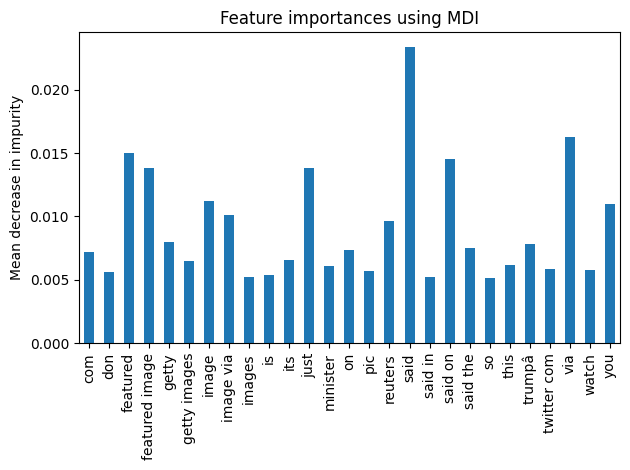

In [103]:
importances = clf.feature_importances_
feature_index = [i for i in range(X_train_tfidf.shape[1])]
words = [ p for p in vectorizer.get_feature_names_out()[feature_index] ]

filtro = importances > 0.005
relevant = importances[filtro]
relevant_words = np.array(words)[filtro]

forest_importances = pd.Series(relevant, index=relevant_words)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


Vemos que palabras como "said", "said on" o "said the" influyen en la decisión. Seguramente porque las noticias reales citan a otros. Este criterio parece sensato y no procede modificar más los datos.

## Word2Vec

In [104]:
# Vectorizador Word2Vec
def tokenize(text):
    return text.lower().split()

X_train_tokens = X_train_text.apply(tokenize)
X_val_tokens = X_val_text.apply(tokenize)
X_test_tokens = X_test_text.apply(tokenize)

w2v_model = Word2Vec(
    sentences=X_train_tokens.tolist(),  # lista de listas de tokens
    vector_size=300,     # dimensión del embedding
    window=5,            # contexto
    min_count=2,         # ignora palabras con frecuencia < 2
    workers=4,           # hilos
    sg=1,                # 1 = skip-gram, 0 = CBOW
    epochs=10,
    seed=42
)

def document_vector(doc_tokens, model):
    # Nos quedamos solo con las palabras que estén en el vocabulario
    vectors = [model.wv[token] for token in doc_tokens if token in model.wv]
    if len(vectors) == 0:
        # Si ninguna palabra está en el vocabulario, devolvemos un vector de ceros
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

def docs_to_matrix(docs_tokens, model):
    return np.vstack([document_vector(tokens, model) for tokens in docs_tokens])

X_train_w2v = docs_to_matrix(X_train_tokens, w2v_model)
X_val_w2v = docs_to_matrix(X_val_tokens, w2v_model)
X_test_w2v = docs_to_matrix(X_test_tokens, w2v_model)

print("X_train_w2v shape:", X_train_w2v.shape)
print("X_val_w2v shape:", X_val_w2v.shape)
print("X_test_w2v shape:", X_test_w2v.shape)



X_train_w2v shape: (10571, 300)
X_val_w2v shape: (12334, 300)
X_test_w2v shape: (12334, 300)


Entrenar el clasificador con los vectores Word2Vec

In [105]:
clf_w2v = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

clf_w2v.fit(X_train_w2v, y_train)

# Predicciones
y_val_pred_w2v = clf_w2v.predict(X_val_w2v)
y_test_pred_w2v = clf_w2v.predict(X_test_w2v)

print("=== Word2Vec + RandomForest | Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred_w2v))
print(classification_report(y_val, y_val_pred_w2v))

print("=== Word2Vec + RandomForest | Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred_w2v))
print(classification_report(y_test, y_test_pred_w2v))


=== Word2Vec + RandomForest | Validación ===
Accuracy val: 0.9505432138803308
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      6051
           1       0.94      0.96      0.95      6283

    accuracy                           0.95     12334
   macro avg       0.95      0.95      0.95     12334
weighted avg       0.95      0.95      0.95     12334

=== Word2Vec + RandomForest | Test ===
Accuracy test: 0.9467326090481596
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5975
           1       0.94      0.96      0.95      6359

    accuracy                           0.95     12334
   macro avg       0.95      0.95      0.95     12334
weighted avg       0.95      0.95      0.95     12334



## Bert

Entrenar el clasificador con los vectores Bert

In [106]:
model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def encode_texts(texts, tokenizer, model, batch_size=16, max_length=128):
    """
    texts: lista/Serie de strings
    return: matriz numpy (n_docs, hidden_size)
    """
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = list(texts[i:i + batch_size])

        encoded = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        input_ids = encoded["input_ids"].to(device)
        attention_mask = encoded["attention_mask"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # [batch_size, seq_len, hidden_size]
            last_hidden_state = outputs.last_hidden_state
            # Usamos el token CLS como embedding del documento
            cls_embeddings = last_hidden_state[:, 0, :]  # (batch_size, hidden_size)

        all_embeddings.append(cls_embeddings.cpu().numpy())

    return np.vstack(all_embeddings)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [107]:
X_train_text = X_train["text_without_reuters"]
X_val_text = X_val["text_without_reuters"]
X_test_text = X_test["text_without_reuters"]

X_train_bert = encode_texts(X_train_text, tokenizer, model)
X_val_bert = encode_texts(X_val_text, tokenizer, model)
X_test_bert = encode_texts(X_test_text, tokenizer, model)

print("X_train_bert shape:", X_train_bert.shape)
print("X_val_bert shape:", X_val_bert.shape)
print("X_test_bert shape:", X_test_bert.shape)


X_train_bert shape: (10571, 768)
X_val_bert shape: (12334, 768)
X_test_bert shape: (12334, 768)


Ahora clasificamos sobre los embeddings

In [108]:
clf_bert = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

clf_bert.fit(X_train_bert, y_train)

# Predicciones
y_val_pred_bert = clf_bert.predict(X_val_bert)
y_test_pred_bert = clf_bert.predict(X_test_bert)

print("=== BERT embeddings + RandomForest | Validación ===")
print("Accuracy val:", accuracy_score(y_val, y_val_pred_bert))
print(classification_report(y_val, y_val_pred_bert))

print("=== BERT embeddings + RandomForest | Test ===")
print("Accuracy test:", accuracy_score(y_test, y_test_pred_bert))
print(classification_report(y_test, y_test_pred_bert))


=== BERT embeddings + RandomForest | Validación ===
Accuracy val: 0.9122750121615048
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6051
           1       0.91      0.92      0.91      6283

    accuracy                           0.91     12334
   macro avg       0.91      0.91      0.91     12334
weighted avg       0.91      0.91      0.91     12334

=== BERT embeddings + RandomForest | Test ===
Accuracy test: 0.9069239500567536
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5975
           1       0.92      0.90      0.91      6359

    accuracy                           0.91     12334
   macro avg       0.91      0.91      0.91     12334
weighted avg       0.91      0.91      0.91     12334



# RED NEURONAL

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

# MLP para clasificación binaria
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)  # salida logit
        )

    def forward(self, x):
        # salida (batch,)
        return self.net(x).squeeze(1)


def make_dataloader(X, y, batch_size=64, shuffle=False):
    """
    X: numpy array (n_samples, n_features)
    y: pandas Series o array (n_samples,)
    """
    X = np.asarray(X, dtype=np.float32)
    y = np.asarray(y, dtype=np.float32)

    X_t = torch.from_numpy(X)
    y_t = torch.from_numpy(y)

    ds = TensorDataset(X_t, y_t)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=shuffle)
    return loader


def train_nn(model, train_loader, val_loader, n_epochs=10, lr=1e-3):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(n_epochs):
        # --------- TRAIN ----------
        model.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * X_batch.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            train_correct += (preds == y_batch).sum().item()
            train_total += y_batch.size(0)

        train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total

        # --------- VALIDATION ----------
        model.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss_sum += loss.item() * X_batch.size(0)
                preds = (torch.sigmoid(logits) >= 0.5).float()
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{n_epochs} | "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        # Guardamos el mejor modelo según accuracy de validación
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"Mejor accuracy de validación: {best_val_acc:.4f}")
    return model


def eval_model(model, X, y_true, nombre=""):
    model.eval()
    X = np.asarray(X, dtype=np.float32)
    y_true = np.asarray(y_true)

    X_t = torch.from_numpy(X).to(device)

    with torch.no_grad():
        logits = model(X_t)
        probs = torch.sigmoid(logits).cpu().numpy().ravel()

    y_pred = (probs >= 0.5).astype(int)

    print(f"\n=== {nombre} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    try:
        print("ROC-AUC:", roc_auc_score(y_true, probs))
    except ValueError:
        print("ROC-AUC: no se puede calcular (solo una clase presente)")

    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    return y_pred, probs

Usando dispositivo: cuda


# Red neuronal con TF-IDF

In [111]:
# Pasamos TF-IDF de sparse matrix a numpy denso
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

input_dim_tfidf = X_train_tfidf_dense.shape[1]
print("Dimensión TF-IDF:", input_dim_tfidf)

# DataLoaders
train_loader_tfidf = make_dataloader(X_train_tfidf_dense, y_train, batch_size=64, shuffle=True)
val_loader_tfidf = make_dataloader(X_val_tfidf_dense, y_val, batch_size=64, shuffle=False)

# Modelo
model_tfidf = MLPClassifier(input_dim=input_dim_tfidf, hidden_dim=256, dropout=0.3)

# Entrenamiento
model_tfidf = train_nn(model_tfidf, train_loader_tfidf, val_loader_tfidf, n_epochs=10, lr=1e-3)

# Evaluación en validación y test
_, _ = eval_model(model_tfidf, X_val_tfidf_dense, y_val, nombre="TF-IDF + MLP | Validación")
_, _ = eval_model(model_tfidf, X_test_tfidf_dense, y_test, nombre="TF-IDF + MLP | Test")


Dimensión TF-IDF: 20000
Epoch 1/10 | train_loss=0.2089, train_acc=0.9470 | val_loss=0.0800, val_acc=0.9762
Epoch 2/10 | train_loss=0.0296, train_acc=0.9923 | val_loss=0.0721, val_acc=0.9765
Epoch 3/10 | train_loss=0.0058, train_acc=0.9989 | val_loss=0.0853, val_acc=0.9743
Epoch 4/10 | train_loss=0.0027, train_acc=0.9994 | val_loss=0.0963, val_acc=0.9761
Epoch 5/10 | train_loss=0.0017, train_acc=0.9997 | val_loss=0.1114, val_acc=0.9708
Epoch 6/10 | train_loss=0.0021, train_acc=0.9995 | val_loss=0.1077, val_acc=0.9753
Epoch 7/10 | train_loss=0.0013, train_acc=0.9998 | val_loss=0.1099, val_acc=0.9756
Epoch 8/10 | train_loss=0.0011, train_acc=0.9997 | val_loss=0.1228, val_acc=0.9739
Epoch 9/10 | train_loss=0.0015, train_acc=0.9999 | val_loss=0.1226, val_acc=0.9753
Epoch 10/10 | train_loss=0.0009, train_acc=0.9998 | val_loss=0.1265, val_acc=0.9757
Mejor accuracy de validación: 0.9765

=== TF-IDF + MLP | Validación ===
Accuracy: 0.9756769904329495
F1: 0.9760498163819256
ROC-AUC: 0.9957826378

# Red neuronal con Word2Vec

In [ ]:
X_train_w2v_dense = np.asarray(X_train_w2v, dtype=np.float32)
X_val_w2v_dense = np.asarray(X_val_w2v, dtype=np.float32)
X_test_w2v_dense = np.asarray(X_test_w2v, dtype=np.float32)

input_dim_w2v = X_train_w2v_dense.shape[1]
print("Dimensión Word2Vec:", input_dim_w2v)

train_loader_w2v = make_dataloader(X_train_w2v_dense, y_train, batch_size=64, shuffle=True)
val_loader_w2v = make_dataloader(X_val_w2v_dense, y_val, batch_size=64, shuffle=False)

model_w2v = MLPClassifier(input_dim=input_dim_w2v, hidden_dim=128, dropout=0.3)

model_w2v = train_nn(model_w2v, train_loader_w2v, val_loader_w2v, n_epochs=10, lr=1e-3)

_, _ = eval_model(model_w2v, X_val_w2v_dense, y_val, nombre="Word2Vec + MLP | Validación")
_, _ = eval_model(model_w2v, X_test_w2v_dense, y_test, nombre="Word2Vec + MLP | Test")


Dimensión Word2Vec: 300
Epoch 1/10 | train_loss=0.3254, train_acc=0.8712 | val_loss=0.1595, val_acc=0.9484
Epoch 2/10 | train_loss=0.1434, train_acc=0.9555 | val_loss=0.1195, val_acc=0.9624
Epoch 3/10 | train_loss=0.1213, train_acc=0.9628 | val_loss=0.1188, val_acc=0.9610
Epoch 4/10 | train_loss=0.1111, train_acc=0.9674 | val_loss=0.1007, val_acc=0.9705
Epoch 5/10 | train_loss=0.0999, train_acc=0.9699 | val_loss=0.0916, val_acc=0.9715
Epoch 6/10 | train_loss=0.0990, train_acc=0.9704 | val_loss=0.1112, val_acc=0.9627
Epoch 7/10 | train_loss=0.0945, train_acc=0.9704 | val_loss=0.0900, val_acc=0.9702
Epoch 8/10 | train_loss=0.0893, train_acc=0.9727 | val_loss=0.0860, val_acc=0.9719
Epoch 9/10 | train_loss=0.0859, train_acc=0.9715 | val_loss=0.0794, val_acc=0.9737
Epoch 10/10 | train_loss=0.0836, train_acc=0.9711 | val_loss=0.0794, val_acc=0.9732
Mejor accuracy de validación: 0.9737

=== Word2Vec + MLP | Validación ===
Accuracy: 0.9732446894762445
F1: 0.9736042233242681
ROC-AUC: 0.99575858

# Red neuronal con embeddings BERT

In [113]:
X_train_bert_dense = np.asarray(X_train_bert, dtype=np.float32)
X_val_bert_dense = np.asarray(X_val_bert, dtype=np.float32)
X_test_bert_dense = np.asarray(X_test_bert, dtype=np.float32)

input_dim_bert = X_train_bert_dense.shape[1]
print("Dimensión BERT:", input_dim_bert)

train_loader_bert = make_dataloader(X_train_bert_dense, y_train, batch_size=64, shuffle=True)
val_loader_bert = make_dataloader(X_val_bert_dense, y_val, batch_size=64, shuffle=False)

model_bert_nn = MLPClassifier(input_dim=input_dim_bert, hidden_dim=256, dropout=0.3)

model_bert_nn = train_nn(model_bert_nn, train_loader_bert, val_loader_bert, n_epochs=10, lr=1e-3)

_, _ = eval_model(model_bert_nn, X_val_bert_dense, y_val, nombre="BERT embeddings + MLP | Validación")
_, _ = eval_model(model_bert_nn, X_test_bert_dense, y_test, nombre="BERT embeddings + MLP | Test")


Dimensión BERT: 768
Epoch 1/10 | train_loss=0.2189, train_acc=0.9155 | val_loss=0.1594, val_acc=0.9360
Epoch 2/10 | train_loss=0.1409, train_acc=0.9436 | val_loss=0.1275, val_acc=0.9500
Epoch 3/10 | train_loss=0.1218, train_acc=0.9501 | val_loss=0.1242, val_acc=0.9518
Epoch 4/10 | train_loss=0.1143, train_acc=0.9538 | val_loss=0.1341, val_acc=0.9482
Epoch 5/10 | train_loss=0.0960, train_acc=0.9587 | val_loss=0.1196, val_acc=0.9538
Epoch 6/10 | train_loss=0.0917, train_acc=0.9606 | val_loss=0.1271, val_acc=0.9501
Epoch 7/10 | train_loss=0.0851, train_acc=0.9645 | val_loss=0.1946, val_acc=0.9328
Epoch 8/10 | train_loss=0.0765, train_acc=0.9683 | val_loss=0.1292, val_acc=0.9521
Epoch 9/10 | train_loss=0.0739, train_acc=0.9688 | val_loss=0.1334, val_acc=0.9505
Epoch 10/10 | train_loss=0.0749, train_acc=0.9698 | val_loss=0.1278, val_acc=0.9549
Mejor accuracy de validación: 0.9549

=== BERT embeddings + MLP | Validación ===
Accuracy: 0.9549213556023999
F1: 0.9558519930125456
ROC-AUC: 0.99165

# BERT como clasificador fine-tuned

In [119]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", device)

model_name = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

train_texts = X_train["text_without_reuters"].tolist()
val_texts   = X_val["text_without_reuters"].tolist()
test_texts  = X_test["text_without_reuters"].tolist()


class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)

        return item


train_dataset = TextDataset(train_texts, y_train, tokenizer)
val_dataset   = TextDataset(val_texts,   y_val,   tokenizer)
test_dataset  = TextDataset(test_texts,  y_test,  tokenizer)

train_loader_tf = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader_tf   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader_tf  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


Dispositivo: cuda


Creamos el modelo de clasifiación y lo entrenamos (fine-tuning)

In [117]:
clf_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2  # binario
).to(device)


def train_transformer(model, train_loader, val_loader, num_epochs=3, lr=2e-5):
    optimizer = AdamW(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(num_epochs):
        # ------- TRAIN -------
        model.train()
        train_loss_sum = 0.0
        train_preds = []
        train_labels = []

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch["input_ids"].size(0)
            preds = torch.argmax(logits, dim=1)

            train_preds.extend(preds.detach().cpu().numpy())
            train_labels.extend(batch["labels"].detach().cpu().numpy())

        train_loss = train_loss_sum / len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)

        # ------- VALID -------
        model.eval()
        val_loss_sum = 0.0
        val_preds = []
        val_labels = []
        val_probs = []

        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                outputs = model(**batch)
                loss = outputs.loss
                logits = outputs.logits

                val_loss_sum += loss.item() * batch["input_ids"].size(0)
                preds = torch.argmax(logits, dim=1)
                probs = torch.softmax(logits, dim=1)[:, 1]

                val_preds.extend(preds.detach().cpu().numpy())
                val_labels.extend(batch["labels"].detach().cpu().numpy())
                val_probs.extend(probs.detach().cpu().numpy())

        val_loss = val_loss_sum / len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds)
        try:
            val_roc = roc_auc_score(val_labels, val_probs)
        except ValueError:
            val_roc = float("nan")

        print(
            f"Epoch {epoch+1}/{num_epochs} | "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, "
            f"val_f1={val_f1:.4f}, val_roc={val_roc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

    if best_state is not None:
        model.load_state_dict(best_state)
        print(f"\nMejor accuracy de validación: {best_val_acc:.4f}")

    return model


clf_model = train_transformer(clf_model, train_loader_tf, val_loader_tf, num_epochs=3, lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | train_loss=0.1055, train_acc=0.9582 | val_loss=0.0626, val_acc=0.9698, val_f1=0.9710, val_roc=0.9980
Epoch 2/3 | train_loss=0.0404, train_acc=0.9809 | val_loss=0.0591, val_acc=0.9776, val_f1=0.9777, val_roc=0.9982
Epoch 3/3 | train_loss=0.0263, train_acc=0.9890 | val_loss=0.0524, val_acc=0.9801, val_f1=0.9805, val_roc=0.9987

Mejor accuracy de validación: 0.9801


Evaluamos el modelo

In [118]:
def eval_transformer(model, data_loader, y_true, nombre="Transformer fine-tuned"):
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits

            probs = torch.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(all_preds)
    y_prob = np.array(all_probs)

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    try:
        roc = roc_auc_score(y_true, y_prob)
    except ValueError:
        roc = float("nan")

    print(f"\n=== {nombre} (TEST) ===")
    print("Accuracy:", acc)
    print("F1:", f1)
    print("ROC-AUC:", roc)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    return y_pred, y_prob


y_pred_test_tf, y_prob_test_tf = eval_transformer(
    clf_model,
    test_loader_tf,
    y_test,
    nombre="Transformer (fine-tuning HuggingFace)"
)



=== Transformer (fine-tuning HuggingFace) (TEST) ===
Accuracy: 0.9788389816766662
F1: 0.9795149517306334
ROC-AUC: 0.998572431522285

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5975
           1       0.98      0.98      0.98      6359

    accuracy                           0.98     12334
   macro avg       0.98      0.98      0.98     12334
weighted avg       0.98      0.98      0.98     12334

